# Thunderbird 2 supercomputer logs EDA

## Introduction
This notebook contains exploratory data analysis of Thunderbird 2 supercomputer logs that is a part of CFDR data (see https://www.usenix.org/cfdr-data). CFDR data contains logs of 22 high-performance computing systems. The workloads run on those systems are large-scale long-running 3D scientific simulations, e.g. for nuclear stockpile stewardship. 

Original dataset used for extracting the sample under analysis is a raw text file containing event logs collected between 2004 and 2006 containing alert and non-alert messages identified by alert category tags. Thunderbird supercomputer logs dataset is suitable for alert detection and prediction research.

## The data set overview
Thunderbird original logs contain 211,212,192 messages, where 3,248,239 of them are related to 10 categories of alerts.  Non-alert messages are starting with "-" mark.

The logs were collected using UDP protocol for transmission. Some alert messages are missing in sample records that was caused by network connection interruption.

The data sample used for further analysis is extracted from the original one as a random subsample containing 0,5% of records.

More detailed dataset description can be found in the paper written by Adam Oliner and Jon Stearley [1].

## References
1. Oliner, Adam & Stearley, Jon. (2007). What Supercomputers Say: A Study of Five System Logs. 575-584. 10.1109/DSN.2007.103. 


# Exploratory data analysis

## I. The dataset overview and preprocessing



Load the dataset:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import featuretools as ft
import gc

data = pd.read_csv("../data/tbird2_sample.csv")
data.head()

,alert_class,message_id,date,host_name,month,day,time,host_privilege,tool,message
0,-,1136327431,2006.01.03,an922,Jan,3,14:30:31,an922/an922,smartd[1976]:,Configuration file /etc/smartd.conf parsed.
1,-,1135346286,2005.12.23,dn669,Dec,23,05:58:06,dn669/dn669,crond[1281]:,(root) CMD (run-parts /etc/cron.hourly)
2,-,1136415929,2006.01.04,bn948,Jan,4,15:05:29,bn948/bn948,kernel:,Probing IDE interface ide4...
3,-,1134356625,2005.12.11,an212,Dec,11,19:03:45,an212/an212,Server,Administrator: Instrumentation Service EventID...
4,-,1135321264,2005.12.22,an23,Dec,22,23:01:04,an23/an23,crond(pam_unix)[6624]:,session closed for user root


Let's take an overview of alert categories:

In [2]:
data.alert_class.value_counts()

-                 219653
R_VAPI              7705
R_MTT               2140
N_CALL_TR            146
R_SCSI1                8
N_NFS                  5
R_MPT                  4
R_EXT_FS_ABRT2         3
R_SCSI0                1
R_EXT_FS_ABRT1         1
R_EXT_INODE2           1
Name: alert_class, dtype: int64

The sample contains 219653 non-alert messages, that is the majority of records.
All other log types belong to different alert types.


All log types are encoded as follows:

In [3]:
log_type_dict = {'-':0, '^(?!.*-).*$':1}

data['alert_class'] = data['alert_class'].replace(log_type_dict, regex=True)

data.alert_class.value_counts()

0    219653
1     10014
Name: alert_class, dtype: int64

Frequency distribution of alert and non-alert messages:

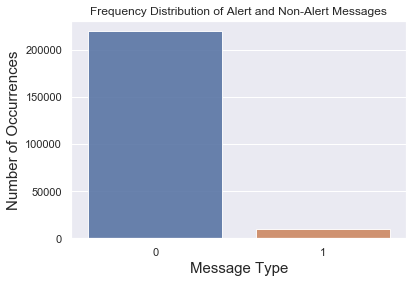

In [4]:
%matplotlib inline
count = data['alert_class'].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('Frequency Distribution of Alert and Non-Alert Messages')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Message Type', fontsize=15)
plt.show()

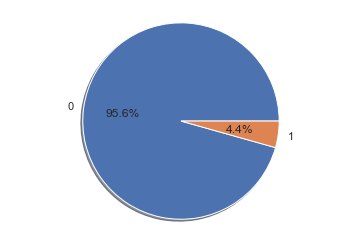

In [5]:
labels = data['alert_class'].astype('category').cat.categories.tolist()
counts = data['alert_class'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

As it is seen from the pie plot above, there are only 4,4% records that behave as anomalies.

Extract new timeseries features from datetime and time columns:

In [6]:
data["date"] = pd.to_datetime(data["date"])
data['month'] = data['date'].dt.month
data['year']  = data['date'].dt.year
data['weekday'] = data['date'].dt.weekday
data.drop(['date'], 1, inplace=True)
data.head()

,alert_class,message_id,host_name,month,day,time,host_privilege,tool,message,year,weekday
0,0,1136327431,an922,1,3,14:30:31,an922/an922,smartd[1976]:,Configuration file /etc/smartd.conf parsed.,2006,1
1,0,1135346286,dn669,12,23,05:58:06,dn669/dn669,crond[1281]:,(root) CMD (run-parts /etc/cron.hourly),2005,4
2,0,1136415929,bn948,1,4,15:05:29,bn948/bn948,kernel:,Probing IDE interface ide4...,2006,2
3,0,1134356625,an212,12,11,19:03:45,an212/an212,Server,Administrator: Instrumentation Service EventID...,2005,6
4,0,1135321264,an23,12,22,23:01:04,an23/an23,crond(pam_unix)[6624]:,session closed for user root,2005,3


In [7]:
temp = pd.to_datetime(data["time"])
data['hour'] = temp.dt.hour
data['minute'] = temp.dt.minute
data['second'] = temp.dt.second
data.drop(['time'], 1, inplace=True)
del temp
gc.collect;

data.head()

,alert_class,message_id,host_name,month,day,host_privilege,tool,message,year,weekday,hour,minute,second
0,0,1136327431,an922,1,3,an922/an922,smartd[1976]:,Configuration file /etc/smartd.conf parsed.,2006,1,14,30,31
1,0,1135346286,dn669,12,23,dn669/dn669,crond[1281]:,(root) CMD (run-parts /etc/cron.hourly),2005,4,5,58,6
2,0,1136415929,bn948,1,4,bn948/bn948,kernel:,Probing IDE interface ide4...,2006,2,15,5,29
3,0,1134356625,an212,12,11,an212/an212,Server,Administrator: Instrumentation Service EventID...,2005,6,19,3,45
4,0,1135321264,an23,12,22,an23/an23,crond(pam_unix)[6624]:,session closed for user root,2005,3,23,1,4


Investigate **tool** feature:

In [5]:
data['tool'].value_counts()

kernel:                                                 101826
ib_sm.x[24904]:                                          25099
Server                                                    8894
/apps/x86_64/system/ganglia-3.0.1/sbin/gmetad[1684]:      5074
dhcpd:                                                    4406
sysctl:                                                   3971
ib_sm.x[15679]:                                           2247
rc.sysinit:                                               1473
fsck:                                                     1459
logger:                                                   1097
dataeng:                                                  1024
VFS:                                                       837
kernel:\r\n                                                639
pbs_mom:                                                   608
ntpd:                                                      572
mount:                                                 

Processes names are in the following forms:
1. ***process_name:***
2. ***process_name [process_id]:***
3. ***process_name(authentication_module) [process_id]:***


In [8]:
data['tool'] = data['tool'].apply(lambda x: x.replace(':', '').replace('\r\n', ''))
data['process_id'] = data['tool'].str.extract('.*\[(.*)\].*')
data['tool'] = data['tool'].str.replace(r"\[.*\]","") # delete process id from tool description
data['tool_name'] = data['tool'].str.replace(r"\(.*\)","")
data['authentication'] = data['tool'].str.extract('.*\((.*)\).*')
data.drop(['tool'], 1, inplace=True)

data.head()

,alert_class,message_id,host_name,month,day,host_privilege,message,year,weekday,hour,minute,second,process_id,tool_name,authentication
0,0,1136327431,an922,1,3,an922/an922,Configuration file /etc/smartd.conf parsed.,2006,1,14,30,31,1976,smartd,NaN
1,0,1135346286,dn669,12,23,dn669/dn669,(root) CMD (run-parts /etc/cron.hourly),2005,4,5,58,6,1281,crond,NaN
2,0,1136415929,bn948,1,4,bn948/bn948,Probing IDE interface ide4...,2006,2,15,5,29,NaN,kernel,NaN
3,0,1134356625,an212,12,11,an212/an212,Administrator: Instrumentation Service EventID...,2005,6,19,3,45,NaN,Server,NaN
4,0,1135321264,an23,12,22,an23/an23,session closed for user root,2005,3,23,1,4,6624,crond,pam_unix


In [17]:
data['host_privilege'].value_counts()

src@tbird-sm1            27475
an690/an690               9857
bn971/bn971               8900
local@tbird-admin1        6718
dn866/dn866               5175
bn410/bn410               4642
dn825/dn825               3980
dn30/dn30                 3599
dn871/dn871               2533
dn868/dn868               2070
dn875/dn875               1920
src@aadmin1               1096
src@badmin1               1017
dn1013/dn1013              966
bn575/bn575                796
src@eadmin1                746
src@dadmin1                683
src@cadmin1                679
an933/an933                670
an416/an416                632
src@aadmin2                604
#1#/#1#                    569
src@aadmin3                524
src@dadmin2                524
src@cadmin2                487
bn278/bn278                472
src@dadmin3                469
src@aadmin4                455
src@badmin2                430
cn110/cn110                407
                         ...  
cr13iblsw1/cr13iblsw1        1
dr2iblsw

In [7]:
data['tool_name'].value_counts()

kernel                                           102465
ib_sm.x                                           27677
crond                                             21174
sshd                                              10820
snmpd                                              9682
Server                                             8894
xinetd                                             7795
ntpd                                               7051
/apps/x86_64/system/ganglia-3.0.1/sbin/gmetad      5097
dhcpd                                              4428
sysctl                                             3971
sendmail                                           1883
smartd                                             1738
rc.sysinit                                         1473
fsck                                               1459
logger                                             1097
dataeng                                            1024
VFS                                             

In [6]:
data['authentication'].value_counts()

pam_unix    19552
1               1
Name: authentication, dtype: int64

If log is marked with **pam_unix** authentication, it means that the session is opened or closed. Otherwise, session can be already running, so now all values having session state different from **pam_unix** value will be replaced, as there is a lack of context for such logs:

In [11]:
data['authentication'].fillna('other', inplace = True)
data[data['authentication']!='pam_unix']['authentication'] = 'other'

data['authentication'].value_counts()

other       210114
pam_unix     19552
1                1
Name: authentication, dtype: int64

In [12]:
data.head()

,alert_class,message_id,host_name,month,day,host_privilege,message,year,weekday,hour,minute,second,process_id,tool_name,authentication
0,0,1136327431,an922,1,3,an922/an922,Configuration file /etc/smartd.conf parsed.,2006,1,14,30,31,1976,smartd,other
1,0,1135346286,dn669,12,23,dn669/dn669,(root) CMD (run-parts /etc/cron.hourly),2005,4,5,58,6,1281,crond,other
2,0,1136415929,bn948,1,4,bn948/bn948,Probing IDE interface ide4...,2006,2,15,5,29,NaN,kernel,other
3,0,1134356625,an212,12,11,an212/an212,Administrator: Instrumentation Service EventID...,2005,6,19,3,45,NaN,Server,other
4,0,1135321264,an23,12,22,an23/an23,session closed for user root,2005,3,23,1,4,6624,crond,pam_unix


In [9]:
data['process_id'].value_counts()

24904    25099
1684      5075
15679     2248
1990       532
1989       430
1607       396
1991       365
2264       277
1979       276
2260       268
2256       265
2261       262
2263       258
900        252
2257       237
1978       232
2258       231
2259       220
1993       210
2262       203
2265       196
2276       193
1949       192
2272       186
1985       185
1980       184
2275       184
2285       173
2286       171
2274       168
         ...  
12926        1
28176        1
31604        1
10412        1
26465        1
20385        1
17533        1
26189        1
1874         1
31802        1
29390        1
26531        1
12251        1
14418        1
32716        1
31742        1
6874         1
13225        1
11567        1
24258        1
8295         1
11071        1
30283        1
22252        1
15190        1
10143        1
6613         1
31147        1
1085         1
7725         1
Name: process_id, Length: 19526, dtype: int64

In [10]:
data['message_id'].value_counts()

1136998512    52
1136998511    51
1131671702    51
1131671701    51
1136322009    46
1132696361    44
1132695529    44
1131671706    44
1132696069    43
1131671705    42
1131671712    42
1136998510    42
1131671715    42
1132695530    41
1136415726    41
1136477689    41
1136932436    41
1132695521    41
1131671704    40
1132696543    40
1137003438    40
1132696548    40
1136477688    39
1132696544    39
1132695589    39
1136386427    39
1137004648    38
1132695711    38
1131671707    38
1132695710    37
              ..
1134663398     1
1136349883     1
1132357517     1
1132657277     1
1132239554     1
1134072515     1
1136437956     1
1135623372     1
1132772038     1
1136706249     1
1136712394     1
1135672014     1
1136096207     1
1132462801     1
1135880916     1
1136737014     1
1134840536     1
1136417498     1
1132489436     1
1135633117     1
1135375071     1
1135708896     1
1131774689     1
1135715045     1
1132575462     1
1133309024     1
1136466674     1
1131746035    

## II. Missing entries overview

In [13]:
data.isnull().sum()

alert_class            0
message_id             0
host_name              0
month                  0
day                    0
host_privilege         0
message              850
year                   0
weekday                0
hour                   0
minute                 0
second                 0
process_id        135590
tool_name              0
authentication         0
dtype: int64

850 entries have logs with lost messages. As the message was missing due to the connection failure, all missing values are going to be replaced with 'Connection failure' message.

In [14]:
data['message'].fillna("Connection failure", inplace = True)
data.isnull().sum()

alert_class            0
message_id             0
host_name              0
month                  0
day                    0
host_privilege         0
message                0
year                   0
weekday                0
hour                   0
minute                 0
second                 0
process_id        135590
tool_name              0
authentication         0
dtype: int64

## III. Feature engineering



## IV. Features correlation heatmap

In [ ]:
data.head()

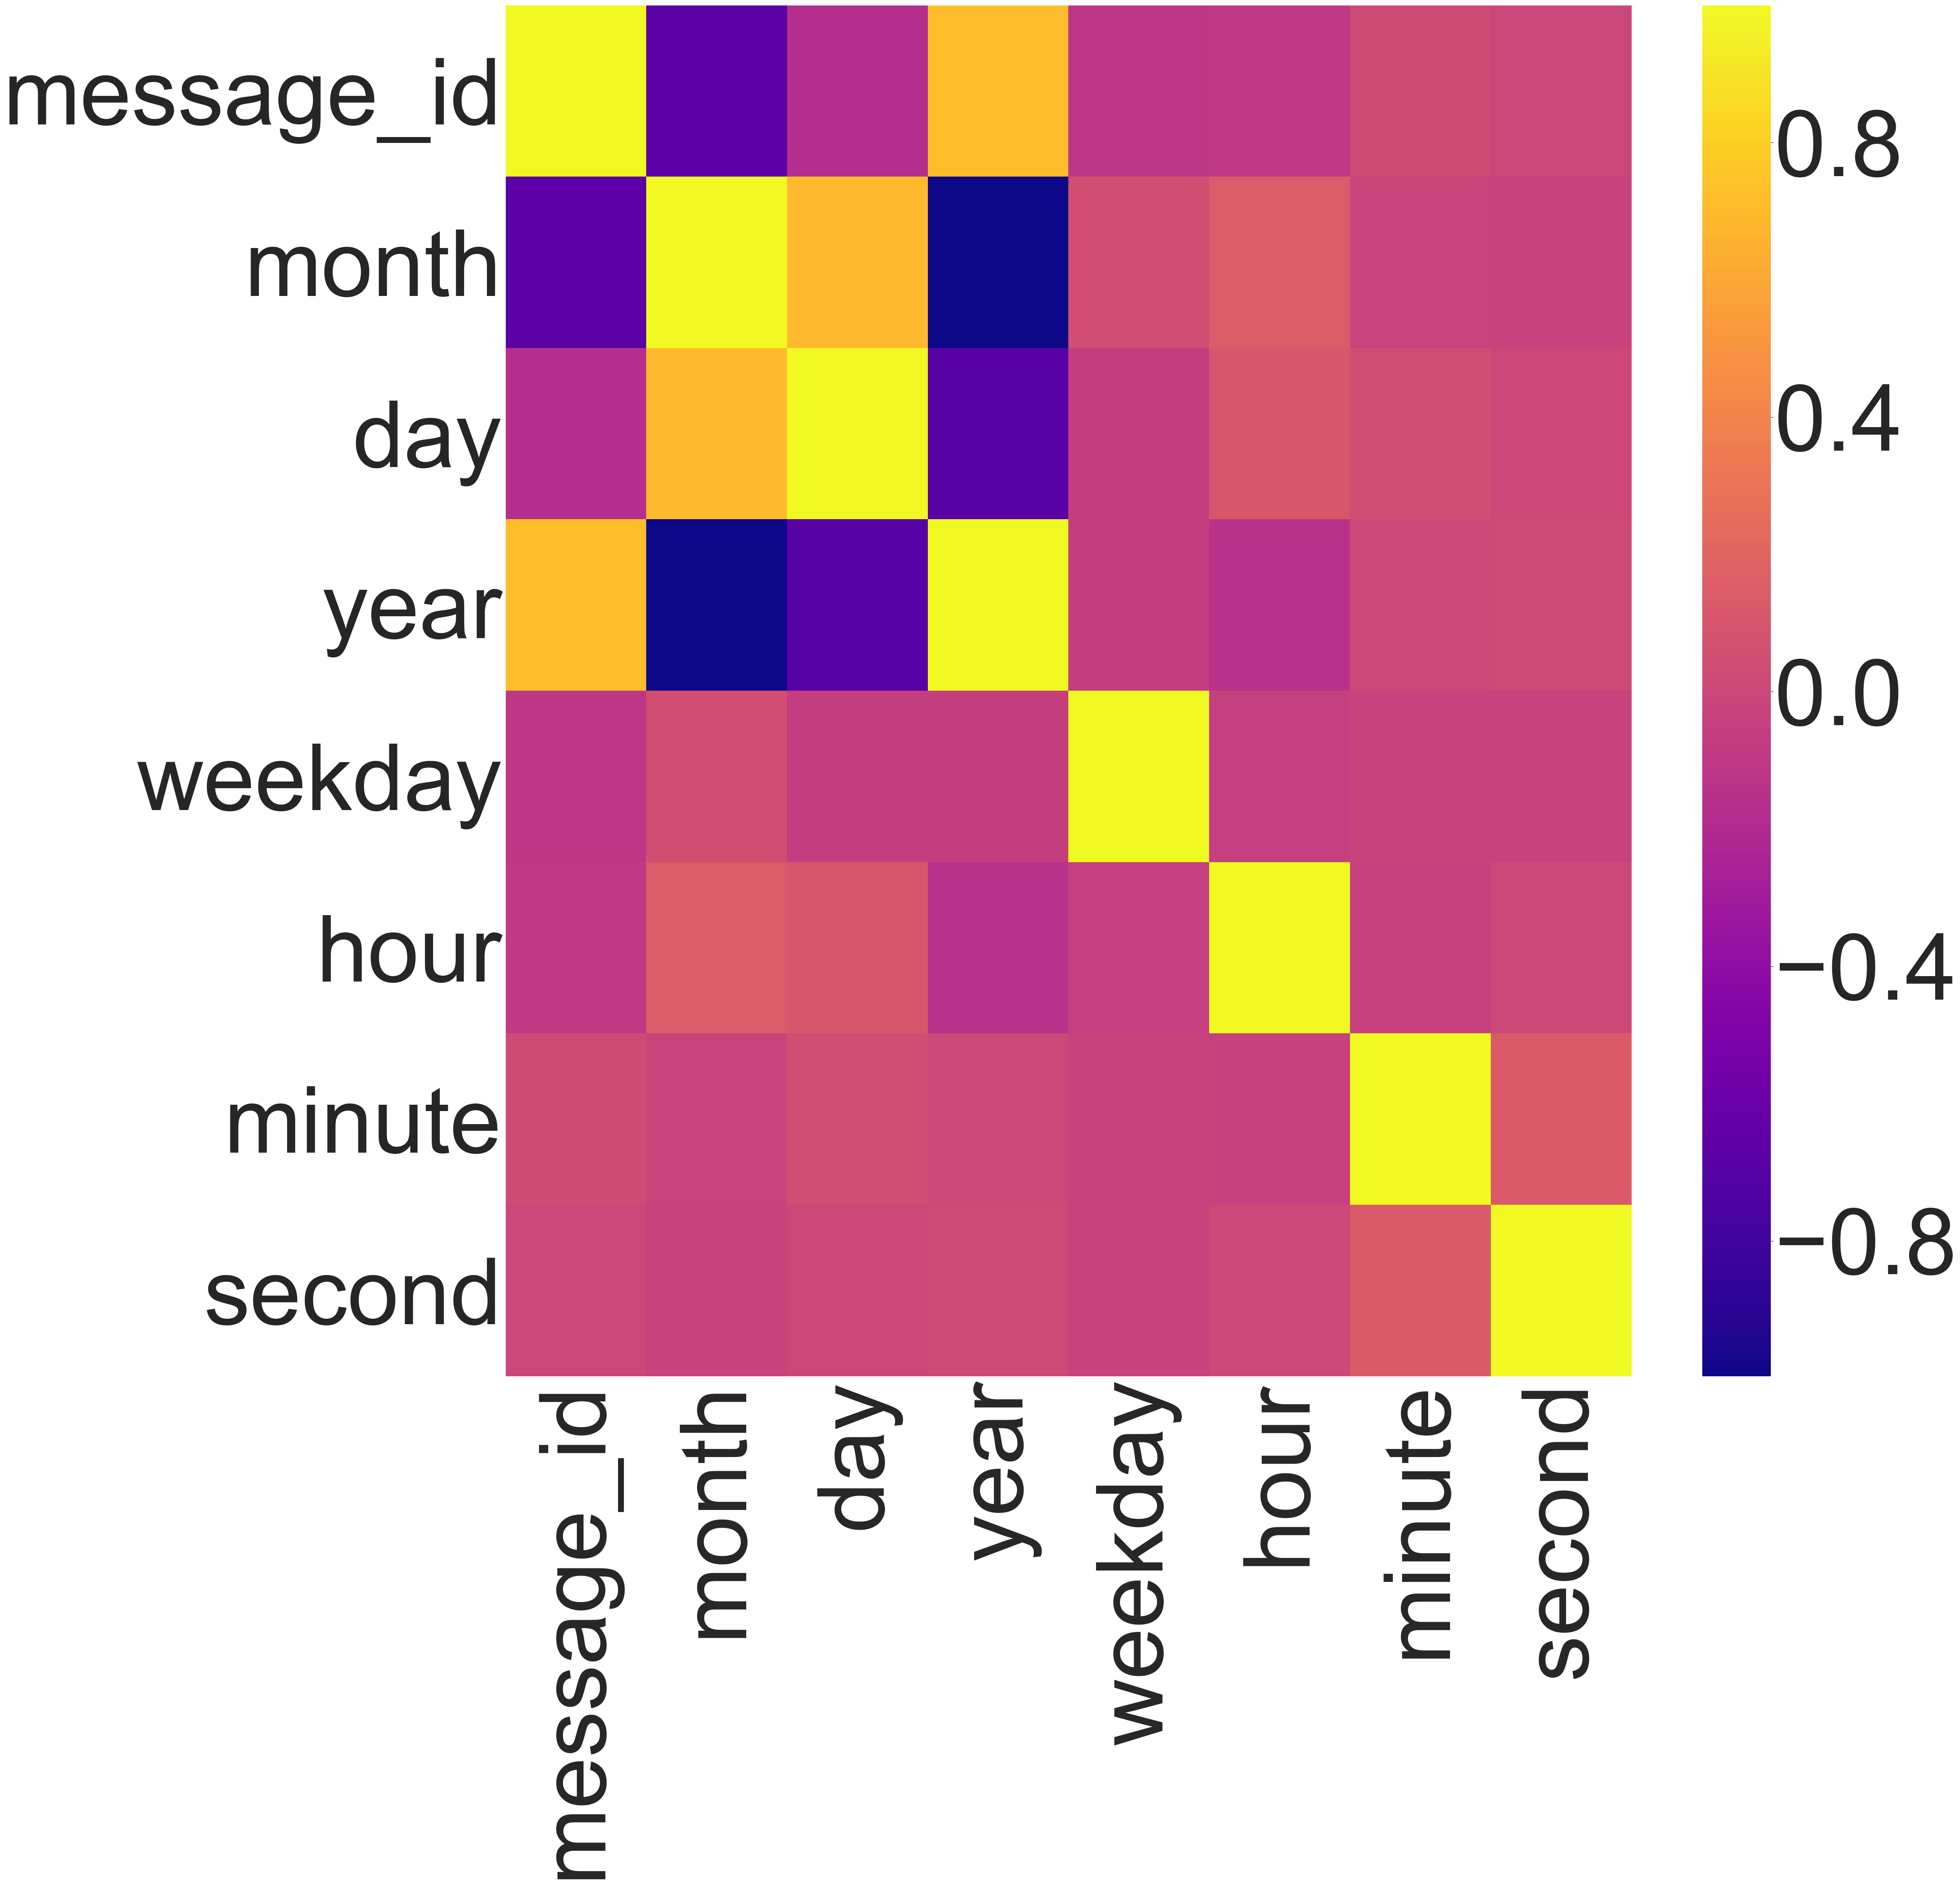

In [17]:
fig, ax = plt.subplots(figsize=(60, 60))
sns.set(font_scale=20)
features = data.loc[:, data.columns != 'alert_class']
correlation_matrix = features.corr(method='pearson', min_periods=1)
sns.heatmap(correlation_matrix, ax=ax, cmap="plasma", fmt="d")
ax.set_ylabel('')
ax.set_xlabel('')
plt.show()

As it is seen in the heatmap above, the majority of features have Pearson's correlation coefficient values around 0, meaning that the majority of features are not linearly strongly correlated nor have strong negative linear correlation.
Features extracted from the timeframe attributte have strong negative linear correlation (marked with dark blue) or have extremely high linear correlation (marked with bright yellow). Interestingly, **message_id** feature has a strongly negative linear correlation with some of features engineered from the timestamp value, but still not with all of them.
Features that are out of Pearson's linear correlation values range [0.2, 0.8] are going to be dropped out from the features set for reducing bias.
